<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# EP 2 Notebook
**Nome:** André Barbosa

**Numero Usp:** 7971751













______________

In [1]:
from collections import Counter
import re

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tqdm.notebook import tqdm
tf.get_logger().setLevel('ERROR')

## Prepare o dataset



Precisa lembrar de falar que o dataset inicial está separado com ';'

In [2]:
np.random.seed(42)


def preprocess_embedding_from_NILC(embedding_path_origin: str, embed_dim: int):
    # Pré-processa embedding baseado na lista 04
    N = 929606
    with open(f"data/cbow_s{embed_dim}.txt", "r") as file:
        head = [next(file) for x in range(N)]

    head[0] = str(N - 1) + " " + f"{embed_dim}" + "\n"  # Conserta contagem de palavras
    vocab = set()
    with open(f"data/word2vec_{embed_dim}dim_200k.txt", "w") as file:
        i = 0
        iter_rows = iter(head)
        next(iter_rows)
        for line in tqdm(
            iter_rows, total=N, desc="Preprocessing Embeddings from NILC file"
        ):
            word_vector = line.split()
            word = word_vector[0]
            embedding = word_vector[1:]
            if len(embedding) != embed_dim:
                print(f"word line {i} is corrupt, skipping it.")
                continue
            i += 1
            if word in vocab:
                continue
            vocab.add(word)
            file.write(line)
    return None

In [3]:
def filtro(b2wCorpus: pd.DataFrame) -> pd.DataFrame:
    df = b2wCorpus[["review_text", "overall_rating"]].copy()
    df = df[df["overall_rating"].isin([0, 1, 2, 3, 4, 5])]
    return df.reset_index(drop=True)

In [4]:
def partilha(
    path_original_dataset: str,
    train_proportion=0.65,
    val_proportion=0.1,
    test_proportion=0.25,
    sep=";",
) -> pd.DataFrame:
    if (train_proportion + val_proportion + test_proportion) != 1:
        raise ValueError("Train, Validation and Test size should always be 1")

    b2wCorpus = pd.read_csv(path_original_dataset, sep=sep)
    df = filtro(b2wCorpus)
    X_train, X_val, y_train, y_val = train_test_split(
            df["review_text"],
            df["overall_rating"],
            train_size=0.8,
            random_state=42,
            stratify=df["overall_rating"],
        )

    train_df = pd.DataFrame([X_train, y_train]).T
    val_df = pd.DataFrame([X_val, y_val]).T
    X_val, X_test, y_val, y_test = train_test_split(
            val_df["review_text"],
            val_df["overall_rating"],
            train_size=val_proportion/(val_proportion+test_proportion),
            random_state=42,
            stratify=val_df["overall_rating"]
        )
    val_df = pd.DataFrame([X_val, y_val]).T
    test_df = pd.DataFrame([X_test, y_test]).T
    assert len(df) == (len(train_df) + len(val_df) + len(test_df))
    train_df.to_csv("data/train.csv", index=False)
    val_df.to_csv("data/validation.csv", index=False)
    test_df.to_csv("data/test.csv", index=False)
    return None

In [5]:
def gera_embeddings(path: str, embed_dim=50) -> np.ndarray:
    """
    This function gets the NILC embeddings and store it
    as a numpy matrix
    All words are going to be initialized as zero and then
    they are modified according to specific vector
    """
    N = 929592
    #embedding_matrix = np.zeros((N, embed_dim))
    with open(path, "r") as file:
        i=0
        embed_matrix = [np.zeros((2, embed_dim))]
        embed_vocab = []
        for line in tqdm(file, total=N):
            splitted_words = line.split()
            embed_matrix.append(np.array(splitted_words[1:]).reshape(1,-1))
            embed_vocab.append(splitted_words[0])
            i+=1
        embed_matrix = np.vstack(embed_matrix)
    return embed_matrix, embed_vocab

In [7]:
def codifica(
    train_df_text: pd.Series, tammax: int, embed_dim: int
) -> (TextVectorization, np.ndarray):
    embed_matrix, embed_vocab = gera_embeddings(
        f"data/word2vec_{embed_dim}dim_200k.txt"
    )
    tokenizer_layer = TextVectorization(
        max_tokens=len(embed_vocab)+2, #OOV and 0 is used for mask
        standardize="lower_and_strip_punctuation",
        split="whitespace",
        ngrams=None,
        output_mode="int",
        output_sequence_length=tammax,
    )
    tokenizer_layer.set_vocabulary(
        embed_vocab
    )  # we need to set it to follow the same input matrix

    return tokenizer_layer, embed_matrix, embed_vocab

In [8]:
def cria_modelo(
    embed_matrix: np.ndarray,
    tokenizer_layer: TextVectorization,
    lstm_units: int,
    use_birectional: bool,
    dropout_rate: float,
) -> keras.Model:
    vocab_size = embed_matrix.shape[0]
    embed_dim = embed_matrix.shape[1]
    inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_text")
    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        weights=[embed_matrix],
        trainable=False
    )
    lstm_layer = tf.keras.layers.LSTM(units=lstm_units, 
                                      activation='tanh', 
                                      kernel_initializer='glorot_uniform',
                                     )
    bidirectional_layer = tf.keras.layers.Bidirectional(lstm_layer)
    dropout_layer = layers.Dropout(dropout_rate)
    output_layer = layers.Dense(6, activation="softmax")

    x = tokenizer_layer(inputs)
    x = embedding_layer(x)
    if use_birectional:
        x = bidirectional_layer(x)
    else:
        x = lstm_layer(x)
    x = dropout_layer(x)
    outputs = output_layer(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    print(model.summary())
    return model

In [10]:
def treina_modelo(model: keras.Model, df_train: pd.DataFrame, df_val: pd.DataFrame):
    batch_size = 32
    steps_per_epoch = len(df_train) // batch_size
    my_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(
            filepath="data/logs/mymodel_{epoch}",
            save_best_only=True,
            monitor="val_loss",
        ),
    ]
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
          0.001,
          decay_steps=steps_per_epoch*50,
          decay_rate=0.5,
          staircase=False
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr_schedule),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    history = model.fit(
        df_train["review_text"].values,
        df_train["overall_rating"].values,
        batch_size=batch_size,
        epochs=100,
        validation_data=(df_val["review_text"].values, df_val["overall_rating"].values),
        validation_freq=5,
        callbacks=my_callbacks,
        workers=8,
        shuffle=True,
        verbose=1,
    )
    return history

In [11]:
def aplica_treinamento(train_df, val_df, use_birectional, dropout_rate, embed_matrix):
    print(
        f"Aplicando treinamento com birectional {use_birectional} "
        f"e taxa de dropout em {dropout_rate}"
    )
    model = cria_modelo(
        embed_matrix,
        tokenizer_layer,
        lstm_units=32,
        use_birectional=use_birectional,
        dropout_rate=dropout_rate,
    )
    history = treina_modelo(model, train_df, val_df)
    return history, model

In [12]:
def executa_experimento(use_birectional, dropout_rate, train_df, val_df,test_df,embed_matrix):
    history, model = aplica_treinamento(train_df, val_df, use_birectional, dropout_rate, embed_matrix)
    plot_metrics(history, use_birectional, dropout_rate)
    print("Avaliação nos dados de teste")
    results = model.evaluate(
        test_df["review_text"].values, test_df["overall_rating"].values, batch_size=256
    )
    print("test loss, test acc:", results)
    return None

In [13]:
def plot_metrics(history, use_birectional, dropout_rate):
    # summarize history for loss
    # Inspired from here:
    # https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history.history["loss"])
    epochs = range(4, len(history.history["loss"]), 5)
    plt.plot(epochs, history.history["val_loss"])
    plt.title(
        f"Gráfico de loss com bidrecional={use_birectional} e taxa de dropout={dropout_rate*100}%"
    )
    plt.ylabel("loss")
    plt.xlabel("época")
    plt.legend(["treinamento", "validação"], loc="upper right")
    plt.savefig(
        f"data/learning_curve_bidirectional_{use_birectional}_dropout_rate_{dropout_rate}.png"
    )
    plt.show()
    return None

In [14]:
preprocess_embedding_from_NILC("data/bow_s50.txt", 50)
partilha(
    "data/B2W-Reviews01.csv",
    train_proportion=0.8,
    val_proportion=0.1,
    test_proportion=0.1,
    sep=';'
)
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/test.csv")

word line 18578 is corrupt, skipping it.
word line 344526 is corrupt, skipping it.
word line 429810 is corrupt, skipping it.
word line 471545 is corrupt, skipping it.
word line 491022 is corrupt, skipping it.
word line 514562 is corrupt, skipping it.
word line 575944 is corrupt, skipping it.
word line 648148 is corrupt, skipping it.
word line 808734 is corrupt, skipping it.
word line 818647 is corrupt, skipping it.



/Users/abarbosa/.pyenv/versions/nlportugues/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
tokenizer_layer ,embed_matrix, embed_vocab = codifica(
    train_df_text=train_df["review_text"], tammax=256, embed_dim=50
)

Aplicando treinamento com birectional False e taxa de dropout em 0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 256)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 256, 50)           46479700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 46,490,522
Trainable params: 10,822
Non-trai

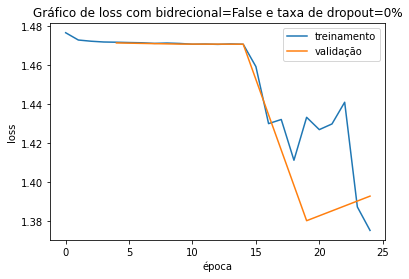

Avaliação nos dados de teste
52/52 [==============================] - 5s 102ms/step - loss: 1.3782 - accuracy: 0.4344
test loss, test acc: [1.378233790397644, 0.43443119525909424]


In [17]:
executa_experimento(False,0, train_df, val_df, test_df, embed_matrix)

Aplicando treinamento com birectional False e taxa de dropout em 0.25
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 256)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 256, 50)           46479700  
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 46,490,522
Trainable params: 10,822
Non-t

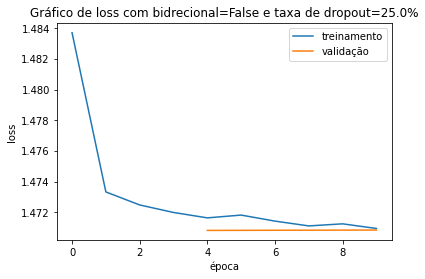

Avaliação nos dados de teste
52/52 [==============================] - 5s 94ms/step - loss: 1.4709 - accuracy: 0.3623
test loss, test acc: [1.4709383249282837, 0.3622903823852539]


In [18]:
executa_experimento(False,0.25, train_df, val_df,test_df, embed_matrix)

Aplicando treinamento com birectional False e taxa de dropout em 0.5
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 256)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 256, 50)           46479700  
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 46,490,522
Trainable params: 10,822
Non-tr

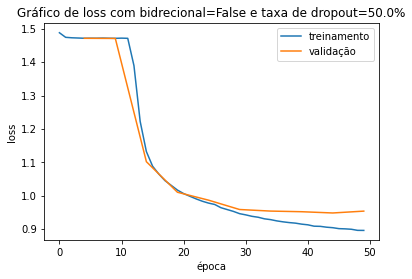

Avaliação nos dados de teste
52/52 [==============================] - 5s 88ms/step - loss: 0.9535 - accuracy: 0.5926
test loss, test acc: [0.9534534811973572, 0.5926121473312378]


In [19]:
executa_experimento(False,0.5, train_df, val_df,test_df, embed_matrix)

Aplicando treinamento com birectional True e taxa de dropout em 0
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 256)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 256, 50)           46479700  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                21248     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 46,501,338
Trainable params: 21,638
Non-train

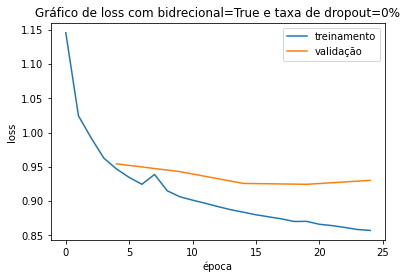

Avaliação nos dados de teste
52/52 [==============================] - 6s 121ms/step - loss: 0.9365 - accuracy: 0.5987
test loss, test acc: [0.9365160465240479, 0.5986554026603699]


In [20]:
executa_experimento(True,0, train_df, val_df,test_df, embed_matrix)

Aplicando treinamento com birectional True e taxa de dropout em 0.25
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 256)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 256, 50)           46479700  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                21248     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 46,501,338
Trainable params: 21,638
Non-tr

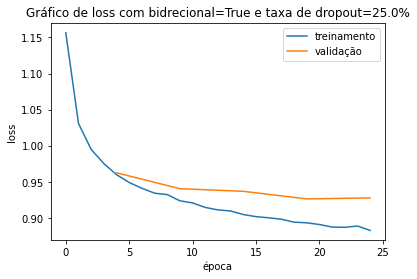

Avaliação nos dados de teste
52/52 [==============================] - 7s 141ms/step - loss: 0.9307 - accuracy: 0.6016
test loss, test acc: [0.9307276010513306, 0.6016014218330383]


In [21]:
executa_experimento(True,0.25, train_df, val_df,test_df, embed_matrix)

Aplicando treinamento com birectional True e taxa de dropout em 0.5
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_text (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 256)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 256, 50)           46479700  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                21248     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 46,501,338
Trainable params: 21,638
Non-tra

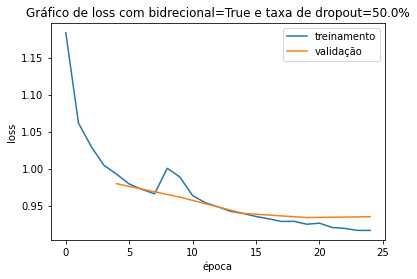

Avaliação nos dados de teste
52/52 [==============================] - 6s 109ms/step - loss: 0.9345 - accuracy: 0.5996
test loss, test acc: [0.9344512224197388, 0.5996373891830444]


In [22]:
executa_experimento(True,0.5, train_df, val_df,test_df, embed_matrix)